In [ ]:
# Colab → mount your drive or upload a "data/" folder containing all 18 CSVs
import pandas as pd
import glob, re

# 1) Gather all CSV file paths
file_paths = glob.glob('/content/drive/MyDrive/sd2files/*.csv')

# 2) Map each "part" number to the fault_severity you ran
fs_mapping = {
    1: 0.4, 2: 0.4, 3: 0.4,   # parts 1–3 were fs=0.4
    4: 0.2, 5: 0.2, 6: 0.2,   # parts 4–6 were fs=0.2
    7: 0.8, 8: 0.8, 9: 0.8    # parts 7–9 were fs=0.8
}

# 3) Load each CSV, extract `part` & `trial` from the filename, annotate
runs = []
for fp in file_paths:
    m = re.search(r'part(\d)([ab])', fp)
    if not m:
        print(f"⚠️  skipped {fp!r}: filename does not match pattern")
        continue

    part, trial = int(m.group(1)), m.group(2)
    fs = fs_mapping[part]

    df = pd.read_csv(fp)
    # rename 'bvn' → 'fa' to match your parameter name
    df = df.rename(columns={'bvn': 'fa'})

    df['fault_severity'] = fs
    df['trial']         = trial
    df['run_id']        = f'part{part}{trial}'
    runs.append(df)

# 4) Concatenate everything
full_df = pd.concat(runs, ignore_index=True)
print("✅ Combined", len(runs), "runs → full_df.shape =", full_df.shape)
print("Columns:", full_df.columns.tolist())

# 5) Quick per‑run summary: avg messages per iteration
#    Here I’m using column 'm' (which your CSV shows) as “messages_sent”
summary_msgs = (
    full_df
      .groupby(['run_id','fa','fm','fault_severity'])
      .agg(avg_m=('m','mean'))
      .reset_index()
)
print(summary_msgs.head())

# 6) Feature engineering: one row per run
features_df = (
    full_df
      .groupby(['run_id','fa','fault_severity'])
      .agg(
          avg_m    = ('m','mean'),
          std_m    = ('m','std'),
          avg_fail = ('fail','mean'),
          avg_rrate= ('rrate','mean')
      )
      .reset_index()
)

# bring in the known target `fm` (constant per run)
features_df = features_df.merge(
    summary_msgs[['run_id','fm']],
    on='run_id', how='left'
)

print("Feature matrix preview:")
print(features_df.head())

# 7) Prepare X, y
X = features_df[['fa','fault_severity','avg_m','std_m','avg_fail','avg_rrate']]
y = features_df['fm']   # small integers (1,2,3)

# 8) Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 9) Fit a Random Forest classifier to predict fm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("\nClassification Report for fm prediction:\n")
print(classification_report(y_test, y_pred))


✅ Combined 18 runs → full_df.shape = (611, 22)
Columns: ['EDEC', 'N', 'iteration', 'Loss', 'sprd', 'fm', 'fa', 'ttc', 'm', 'dm', 'fail', 'rrate', 'pl', 'ratio', 'dd', 'ad', 'w', 't', 'c', 'fault_severity', 'trial', 'run_id']
   run_id  fa  fm  fault_severity      avg_m
0  part1a   1   2             0.4  21.135455
1  part1b   1   2             0.4  21.837727
2  part2a   2   3             0.4  17.129231
3  part2b   2   3             0.4  16.498333
4  part3a   3   4             0.4  12.041739
Feature matrix preview:
   run_id  fa  fault_severity      avg_m     std_m   avg_fail  avg_rrate  fm
0  part1a   1             0.4  21.135455  6.870370   9.363636   0.432773   2
1  part1b   1             0.4  21.837727  6.386228  10.772727   0.430136   2
2  part2a   2             0.4  17.129231  3.497779   2.961538   0.471385   3
3  part2b   2             0.4  16.498333  3.060903   2.400000   0.483900   3
4  part3a   3             0.4  12.041739  1.893370   0.717391   0.487674   4

Classification Rep

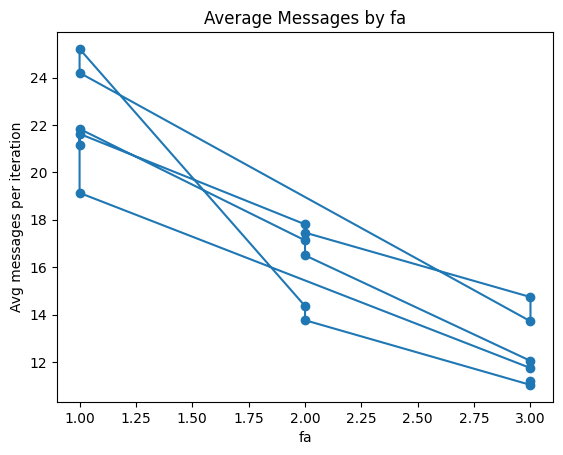

In [ ]:
import matplotlib.pyplot as plt
plt.plot(summary_msgs.fa, summary_msgs.avg_m, 'o-')
plt.xlabel('fa'); plt.ylabel('Avg messages per iteration')
plt.title('Average Messages by fa')
plt.show()


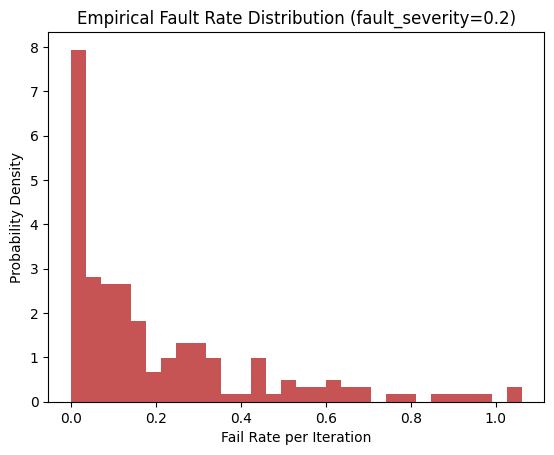

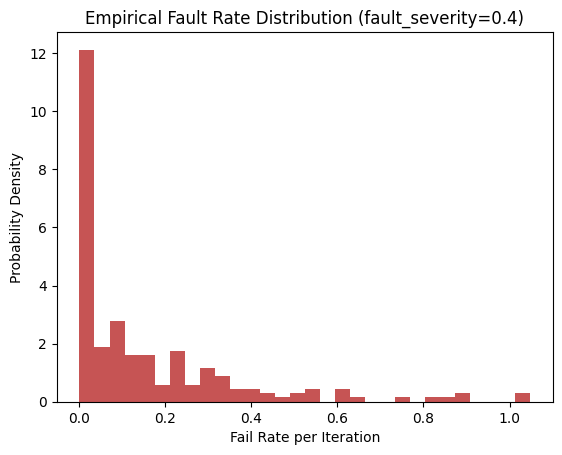

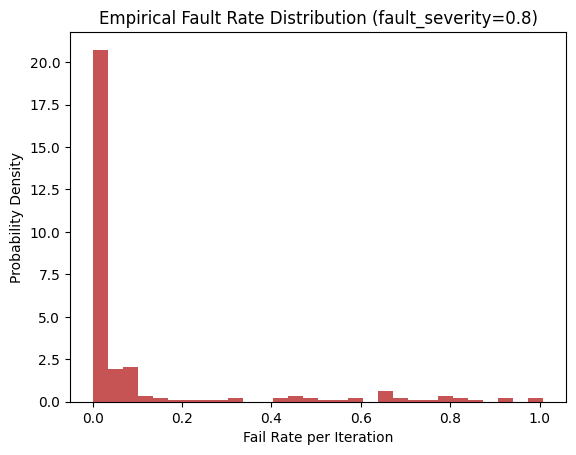

,run_id,fault_severity,mean_fail_rate,std_fail_rate,median_fail_rate
0,part1a,0.4,0.366279,0.266772,0.290831
1,part1b,0.4,0.421951,0.268906,0.322766
2,part2a,0.4,0.148694,0.159372,0.112803
3,part2b,0.4,0.122243,0.154549,0.066169
4,part3a,0.4,0.052697,0.092402,0.000000
5,part3b,0.4,0.042226,0.090987,0.000000
6,part4a,0.2,0.323416,0.304675,0.259269
7,part4b,0.2,0.358073,0.292946,0.298537
8,part5a,0.2,0.199912,0.238427,0.092847
9,part5b,0.2,0.180556,0.223560,0.123686


,fa,fault_severity,avg_messages,avg_failures,avg_fail_rate,avg_ttc
0,1,0.2,20.327609,8.826087,0.339991,1.011545e+06
1,1,0.4,21.486591,10.068182,0.394115,1.033860e+06
2,1,0.8,24.708947,15.421053,0.582050,1.212885e+06
3,2,0.2,17.635455,4.363636,0.190410,8.399317e+05
4,2,0.4,16.791250,2.660714,0.134524,7.999635e+05
5,2,0.8,14.076386,0.373494,0.024390,5.272831e+05
6,3,0.2,14.166857,1.928571,0.118073,6.330331e+05
7,3,0.4,11.884063,0.635417,0.047243,4.730035e+05
8,3,0.8,11.108211,0.089431,0.006498,3.637874e+05


<ipython-input-3-72e3ab2ef1b7>:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=sorted(full_df['fa'].unique()))


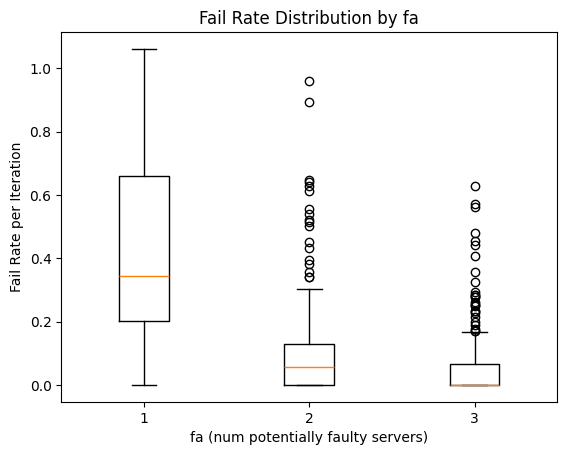

In [ ]:
import pandas as pd
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

# 1) Load and combine all 18 runs
file_paths = glob.glob('/content/drive/MyDrive/sd2files/*.csv')
fs_mapping = {1:0.4, 2:0.4, 3:0.4, 4:0.2, 5:0.2, 6:0.2, 7:0.8, 8:0.8, 9:0.8}

runs = []
for fp in file_paths:
    m = re.search(r'part(\d)([ab])', fp)
    if not m:
        continue
    part, trial = int(m.group(1)), m.group(2)
    df = pd.read_csv(fp).rename(columns={'bvn': 'fa'})
    df['fault_severity'] = fs_mapping[part]
    df['trial'] = trial
    df['run_id'] = f'part{part}{trial}'
    runs.append(df)

full_df = pd.concat(runs, ignore_index=True)

# 2) Compute empirical fail rate per iteration
full_df['fail_rate_iter'] = full_df['fail'] / full_df['m'].replace(0, np.nan)

# 3) Plot probability distributions by fault_severity
for fs in sorted(full_df['fault_severity'].unique()):
    subset = full_df[full_df['fault_severity'] == fs]
    plt.figure()
    plt.hist(subset['fail_rate_iter'].dropna(), bins=30, density=True, color="#C65454")
    plt.title(f'Empirical Fault Rate Distribution (fault_severity={fs})')
    plt.xlabel('Fail Rate per Iteration')
    plt.ylabel('Probability Density')
    plt.show()

# 4) Threat modeling summary
threat_summary = (
    full_df
      .groupby(['run_id', 'fault_severity'])
      .agg(
          mean_fail_rate=('fail_rate_iter', 'mean'),
          std_fail_rate=('fail_rate_iter', 'std'),
          median_fail_rate=('fail_rate_iter', 'median')
      )
      .reset_index()
)
display(threat_summary)

# 5) Overall assessment summary by fa & fault_severity
overall_summary = (
    full_df
      .groupby(['fa', 'fault_severity'])
      .agg(
          avg_messages=('m', 'mean'),
          avg_failures=('fail', 'mean'),
          avg_fail_rate=('fail_rate_iter', 'mean'),
          avg_ttc=('ttc', 'mean'),
      )
      .reset_index()
)
display(overall_summary)

# 6) Boxplot of fail_rate by fa
plt.figure()
data_to_plot = [
    full_df[full_df['fa'] == fa]['fail_rate_iter'].dropna()
    for fa in sorted(full_df['fa'].unique())
]
plt.boxplot(data_to_plot, labels=sorted(full_df['fa'].unique()))
plt.title('Fail Rate Distribution by fa')
plt.xlabel('fa (num potentially faulty servers)')
plt.ylabel('Fail Rate per Iteration')
plt.show()


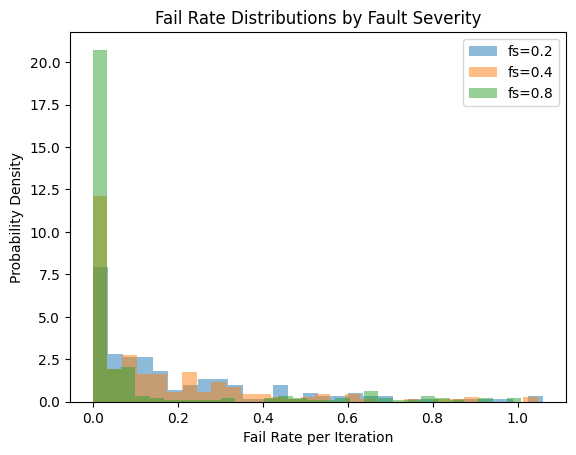

<ipython-input-4-f9da2c05539e>:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)


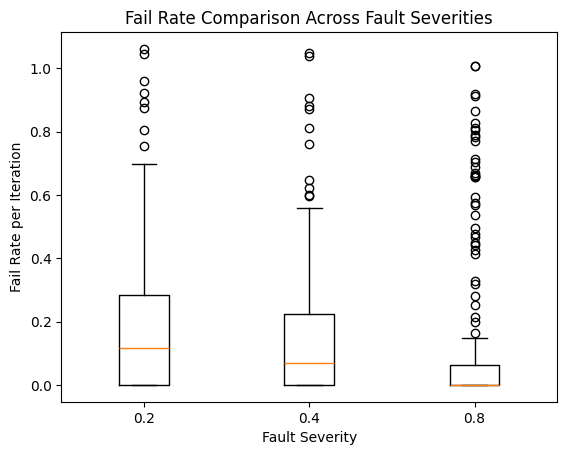

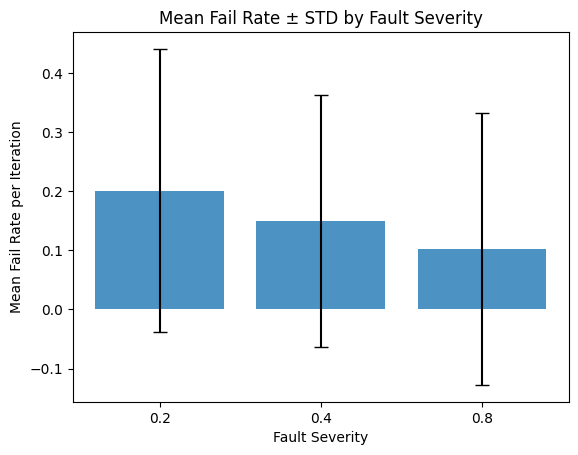

In [ ]:
# Comparative Plots of Fail‑Rate by Fault Severity

import matplotlib.pyplot as plt
import numpy as np

# Assuming `full_df` and `fail_rate_iter` are already defined as in your notebook:
# full_df['fail_rate_iter'] = full_df['fail'] / full_df['m'].replace(0, np.nan)

# 1) Overlapping Histograms of Fail Rate by Fault Severity
plt.figure()
for fs in sorted(full_df['fault_severity'].unique()):
    data = full_df.loc[full_df['fault_severity'] == fs, 'fail_rate_iter'].dropna()
    plt.hist(data, bins=30, density=True, alpha=0.5, label=f'fs={fs}')
plt.title('Fail Rate Distributions by Fault Severity')
plt.xlabel('Fail Rate per Iteration')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# 2) Boxplot Comparison of Fail Rate Across Fault Severities
plt.figure()
data_to_plot = [
    full_df.loc[full_df['fault_severity'] == fs, 'fail_rate_iter'].dropna()
    for fs in sorted(full_df['fault_severity'].unique())
]
labels = [str(fs) for fs in sorted(full_df['fault_severity'].unique())]
plt.boxplot(data_to_plot, labels=labels)
plt.title('Fail Rate Comparison Across Fault Severities')
plt.xlabel('Fault Severity')
plt.ylabel('Fail Rate per Iteration')
plt.show()

# 3) Bar Plot of Mean ± STD Fail Rate by Fault Severity
summary_fs = full_df.groupby('fault_severity')['fail_rate_iter'].agg(['mean','std']).reset_index()
plt.figure()
plt.bar(
    summary_fs['fault_severity'].astype(str),
    summary_fs['mean'],
    yerr=summary_fs['std'],
    capsize=5,
    alpha=0.8
)
plt.title('Mean Fail Rate ± STD by Fault Severity')
plt.xlabel('Fault Severity')
plt.ylabel('Mean Fail Rate per Iteration')
plt.show()


# PREDICTIVE ML MODEL WITH THE 18 FILES - DEEPSEEK

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Mount Google Drive
from google.colab import drive

# Get all CSV files from the specified path
file_paths = glob('/content/drive/MyDrive/sd2files/*.csv')

# Load all CSV files
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Combine all dataframes
data = pd.concat(dfs, ignore_index=True)

# Display basic info
print("Number of files loaded:", len(file_paths))
print("Data shape:", data.shape)
print("\nFirst few rows:")
print(data.head())
print("\nData types and missing values:")
print(data.info())
print("\nDescriptive statistics:")
print(data.describe())

# Preprocessing - Clean the 'Loss' column by removing % and converting to float
data['Loss'] = data['Loss'].str.replace('%', '').astype(float) / 100  # Converts to decimal (0.00% becomes 0.0)

Number of files loaded: 18
Data shape: (611, 19)

First few rows:
   EDEC  N  iteration   Loss  sprd  fm  bvn      ttc      m    dm  fail  \
0     1  5        199  0.00%     5   2    1  2199744  38.15  5.88    40   
1     1  5        187  0.50%     5   2    1  1838116  35.17  5.43    31   
2     1  5        161  1.00%     5   2    1  1560648  30.77  5.18    25   
3     1  5        111  1.50%     5   2    1   963214  21.67  3.72    13   
4     1  5        125  2.00%     5   2    1  1073983  23.27  4.07    13   

   rrate     pl  ratio  dd  ad    w    t    c  
0  0.320  20000   4.77   0   0  942  942    0  
1  0.353  20000   5.71   0   0  942  854   88  
2  0.340  20000   6.73   0   0  942  780  162  
3  0.414  20000  10.90   0   0  942  718  224  
4  0.400  20000   9.78   0   0  942  679  263  

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --

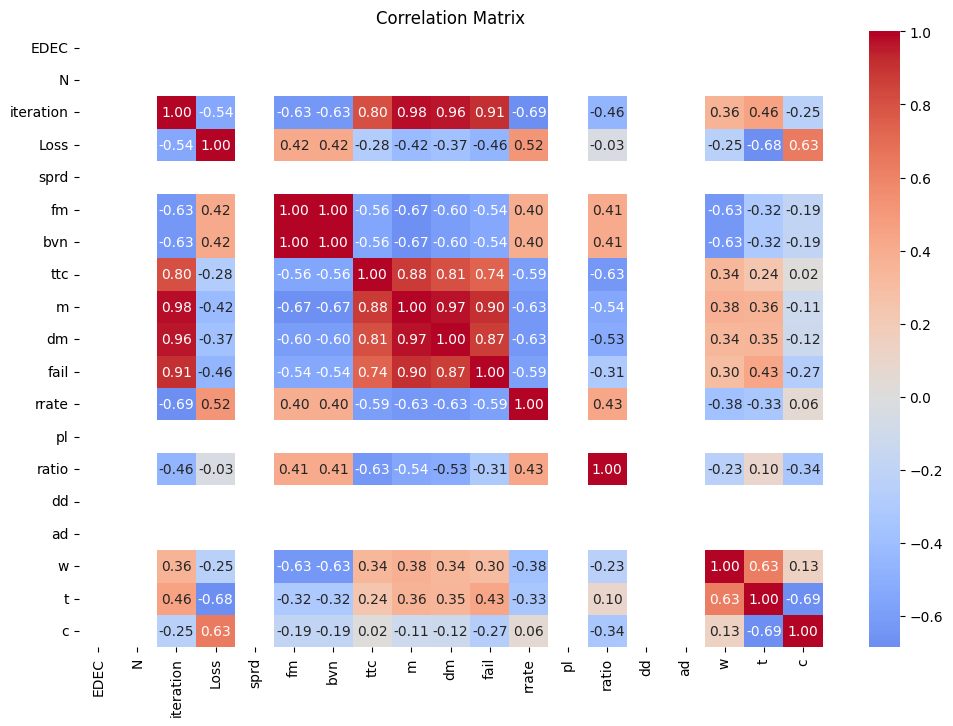


Random Forest Performance:
MAE: 0.1007
MSE: 0.0341
RMSE: 0.1847
R2 Score: 0.9462

Gradient Boosting Performance:
MAE: 0.0653
MSE: 0.0090
RMSE: 0.0948
R2 Score: 0.9858

Linear Regression Performance:
MAE: 0.2233
MSE: 0.0749
RMSE: 0.2737
R2 Score: 0.8819

Ridge Regression Performance:
MAE: 0.2786
MSE: 0.1181
RMSE: 0.3436
R2 Score: 0.8140

Support Vector Regression Performance:
MAE: 0.1415
MSE: 0.0370
RMSE: 0.1924
R2 Score: 0.9416

Model Comparison:
                                MAE       MSE      RMSE        R2
Gradient Boosting          0.065323  0.008982  0.094772  0.985848
Random Forest              0.100732  0.034118  0.184710  0.946244
Support Vector Regression  0.141483  0.037034  0.192443  0.941648
Linear Regression          0.223307  0.074934  0.273740  0.881934
Ridge Regression           0.278593  0.118066  0.343607  0.813974


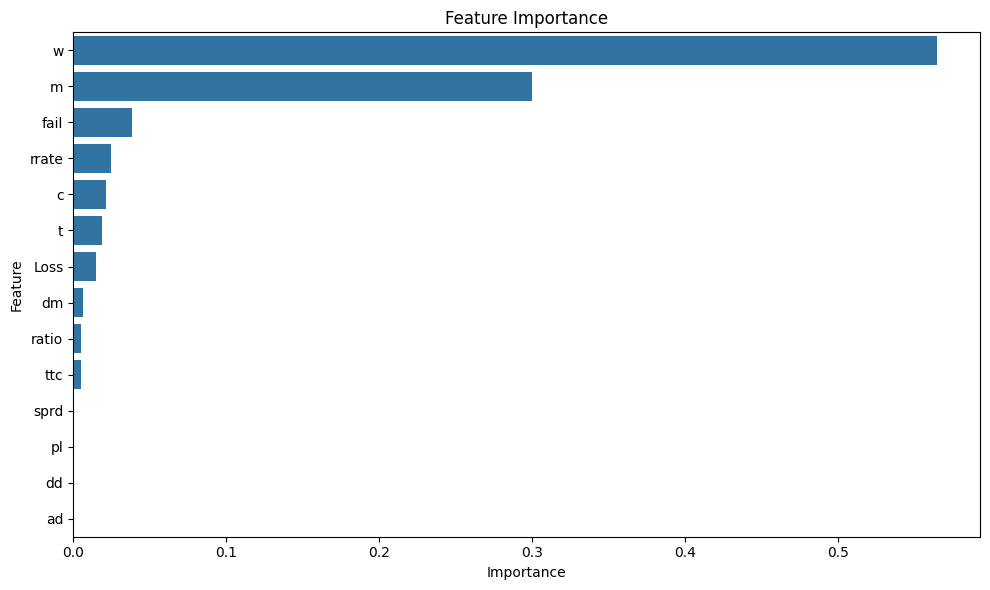


Predicted fm value: 2.88

Model saved to: /content/drive/MyDrive/sd2files/fm_predictor_model.pkl


In [ ]:
# Now calculate correlation matrix
correlation_matrix = data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Preprocessing
# Drop columns that are not useful or might cause data leakage
# Based on the first file, 'fm' is our target, and 'EDEC', 'N' seem to be identifiers
X = data.drop(columns=['fm', 'bvn', 'EDEC', 'N', 'iteration'])  # Adjust based on your actual needs
y = data['fm'].astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to try
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Support Vector Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR())
    ])
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

    print(f"\n{name} Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")

# Compare models
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.sort_values(by='R2', ascending=False))

# Feature importance for the best model (assuming Random Forest is best)
best_model = RandomForestRegressor(random_state=42)
best_model.fit(X_train, y_train)

importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Function to make predictions
def predict_fm(input_data):
    """
    Predict fm values based on input data

    Args:
        input_data (dict or DataFrame): Input features for prediction

    Returns:
        Predicted fm value(s)
    """
    # Convert dict to DataFrame if needed
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    else:
        input_df = input_data.copy()

    # Ensure columns match training data (drop any extra columns)
    input_df = input_df[X.columns]

    # Make prediction
    prediction = best_model.predict(input_df)

    return prediction

# Example usage:
# Create sample input based on the data structure
sample_input = {
    'Loss': 1.0,
    'sprd': 5,
    'bvn': 2,
    'ttc': 1000000,
    'm': 20.0,
    'dm': 3.0,
    'fail': 10,
    'rrate': 0.4,
    'pl': 20000,
    'ratio': 10.0,
    'dd': 0,
    'ad': 0,
    'w': 500,
    't': 400,
    'c': 100
}

predicted_fm = predict_fm(sample_input)
print(f"\nPredicted fm value: {predicted_fm[0]:.2f}")

# Save the model for future use
import joblib
model_path = '/content/drive/MyDrive/sd2files/fm_predictor_model.pkl'
joblib.dump(best_model, model_path)
print(f"\nModel saved to: {model_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


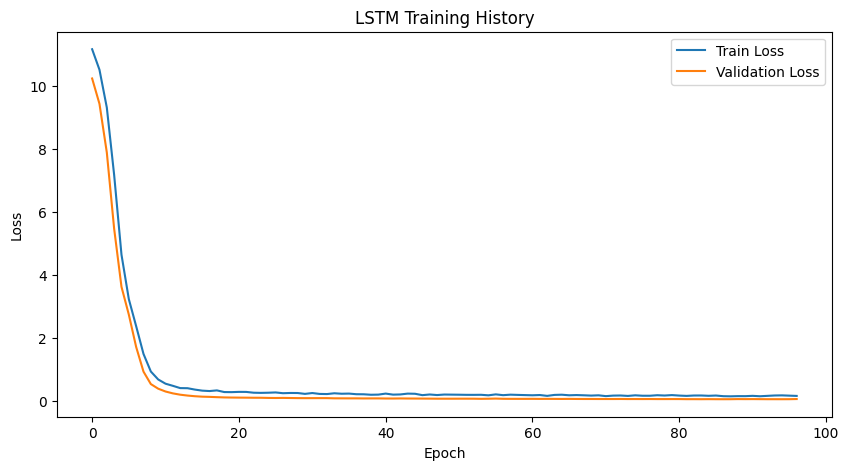


Model Comparison:
                                MAE      RMSE        R2
Gradient Boosting          0.065323  0.094772  0.985848
Support Vector Regression  0.141483  0.192443  0.941648
Random Forest              0.121840  0.208064  0.931791
LSTM                       0.192566  0.239412  0.909689
Linear Regression          0.223307  0.273740  0.881934
Ridge Regression           0.278593  0.343607  0.813974


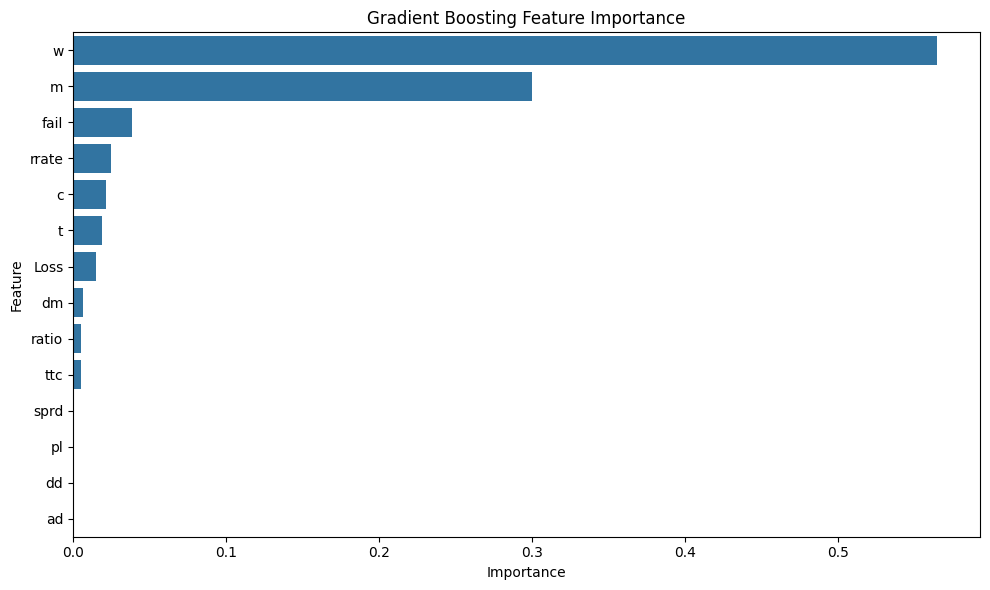

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive

# Load and preprocess data
file_paths = glob('/content/drive/MyDrive/sd2files/*.csv')
dfs = [pd.read_csv(file_path) for file_path in file_paths]
data = pd.concat(dfs, ignore_index=True)

# Clean 'Loss' column
data['Loss'] = data['Loss'].str.replace('%', '').astype(float) / 100

# Remove leaky feature and identifiers
X = data.drop(columns=['fm', 'bvn', 'EDEC', 'N', 'iteration'])
y = data['fm']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard scaling for non-tree models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Existing models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Support Vector Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR())
    ])
}

# Train and evaluate existing models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

# LSTM Model Preparation
# Since your data isn't inherently sequential, we'll treat each sample as a 1-step sequence
n_features = X_train_scaled.shape[1]

# Reshape data for LSTM [samples, timesteps, features]
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(1, n_features), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train LSTM
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# Evaluate LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
results['LSTM'] = {
    'MAE': mean_absolute_error(y_test, y_pred_lstm),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lstm)),
    'R2': r2_score(y_test, y_pred_lstm)
}

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Compare all models
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.sort_values(by='R2', ascending=False))

# Feature importance for best model
best_model_name = results_df['R2'].idxmax()
if best_model_name != 'LSTM':
    if 'Random Forest' in results_df.index:
        model = RandomForestRegressor(random_state=42).fit(X_train, y_train)
        importances = model.feature_importances_
    else:
        model = GradientBoostingRegressor(random_state=42).fit(X_train, y_train)
        importances = model.feature_importances_

    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'{best_model_name} Feature Importance')
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Model Predictions for Sample Input:
Random Forest: 2.2425
Gradient Boosting: 2.1637
Linear Regression: 26.6523
Ridge Regression: 7.7348
Support Vector Regression: 3.0185
LSTM: 0.3918


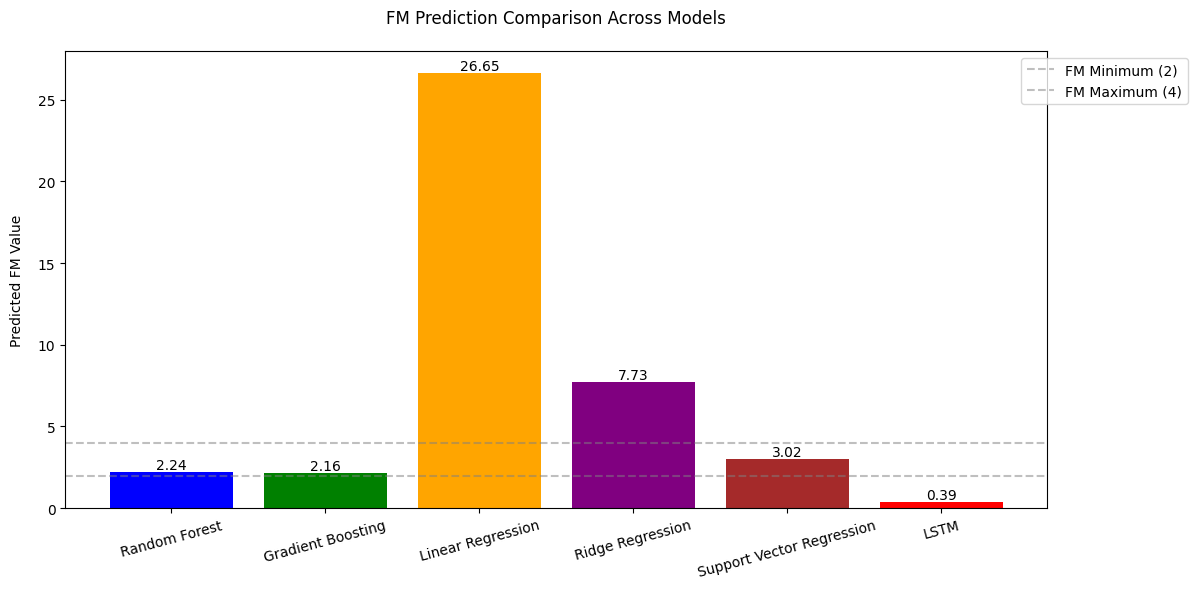

In [ ]:
# Prepare the sample input
# sample_input = {
#     'Loss': 1.0,        # 1.0% loss (already converted to decimal in preprocessing)
#     'sprd': 5,
#     'bvn': 1,
#     'ttc': 1000000,
#     'm': 20.0,
#     'dm': 3.0,
#     'fail': 10,
#     'rrate': 0.4,
#     'pl': 20000,
#     'ratio': 10.0,
#     'dd': 0,
#     'ad': 0,
#     'w': 500,
#     't': 400,
#     'c': 100
# }

sample_input = {
    'Loss': 3.5,
    'sprd': 7,
    'bvn': 1,
    'ttc': 2500000,
    'm': 45.0,
    'dm': 6.2,
    'fail': 18,
    'rrate': 0.65,
    'pl': 35000,
    'ratio': 15.0,
    'dd': 1,
    'ad': 1,
    'w': 800,
    't': 600,
    'c': 200,
}

# Convert sample input to DataFrame
sample_df = pd.DataFrame([sample_input])
sample_df = sample_df[X.columns]  # Ensure correct feature order

# Scale the input (using same scaler as before)
sample_scaled = scaler.transform(sample_df)

# Reshape for LSTM [1 sample, 1 timestep, n_features]
sample_lstm = sample_scaled.reshape(1, 1, -1)

# Get predictions from all models
predictions = {
    'Random Forest': models['Random Forest'].predict(sample_df)[0],
    'Gradient Boosting': models['Gradient Boosting'].predict(sample_df)[0],
    'Linear Regression': models['Linear Regression'].predict(sample_df)[0],
    'Ridge Regression': models['Ridge Regression'].predict(sample_df)[0],
    'Support Vector Regression': models['Support Vector Regression'].predict(sample_df)[0],
    'LSTM': lstm_model.predict(sample_lstm)[0][0]  # LSTM returns 2D array
}

# Display predictions
print("Model Predictions for Sample Input:")
for model_name, pred in predictions.items():
    print(f"{model_name}: {pred:.4f}")

# Visual comparison
plt.figure(figsize=(12, 6))
bars = plt.bar(predictions.keys(), predictions.values(),
               color=['blue', 'green', 'orange', 'purple', 'brown', 'red'])
plt.title("FM Prediction Comparison Across Models", pad=20)
plt.ylabel("Predicted FM Value", labelpad=10)
plt.axhline(y=2, color='gray', linestyle='--', alpha=0.5, label='FM Minimum (2)')
plt.axhline(y=4, color='gray', linestyle='--', alpha=0.5, label='FM Maximum (4)')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction Comparison:
Model                | Previous Sample | New Sample | Delta     
------------------------------------------------------------
Random Forest        | 2.2425          | 2.7126     |  +0.47
Gradient Boosting    | 2.1637          | 3.1631     |  +1.00
Linear Regression    | 26.6523         | 10.5962    | -16.06
Ridge Regression     | 7.7348          | 4.9837     |  -2.75
Support Vector Regression | 3.0185          | 3.0185     |  +0.00
LSTM                 | 0.3918          | 4.9879     |  +4.60


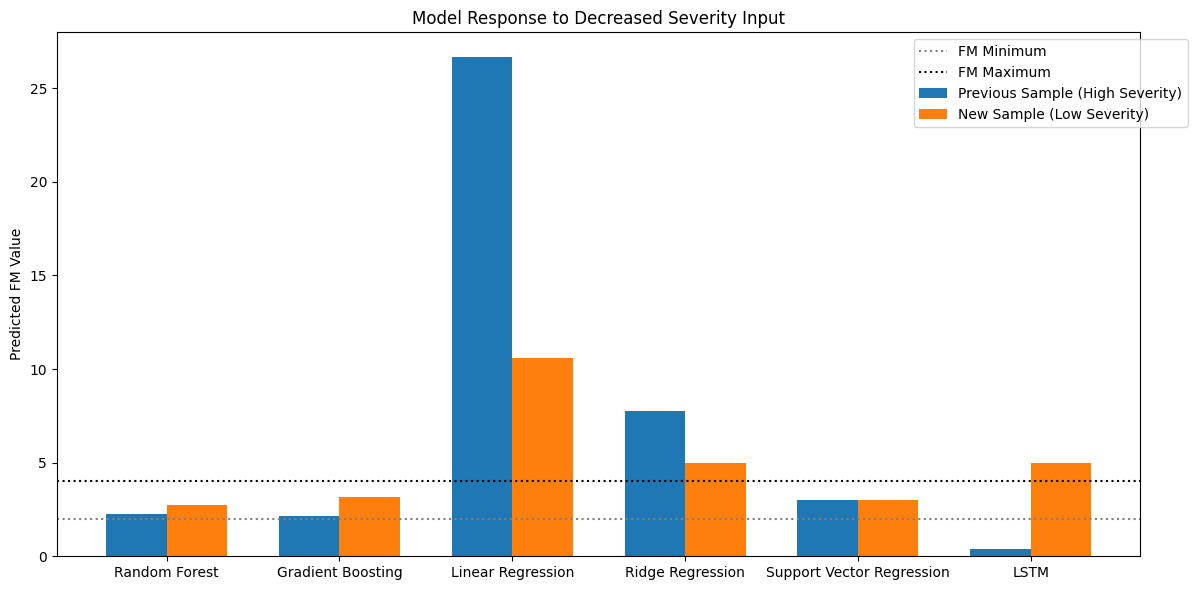

In [ ]:
# new_sample = {
#     'Loss': 3.5,        # Higher loss percentage (3.5%)
#     'sprd': 7,          # Increased spread
#     'bvn': 1,           # Higher BVN value
#     'ttc': 2500000,     # More total transactions
#     'm': 45.0,          # Higher mean value
#     'dm': 6.2,          # Increased delta mean
#     'fail': 18,         # More failures
#     'rrate': 0.65,      # Higher rate
#     'pl': 35000,        # Larger payload
#     'ratio': 15.0,      # Higher ratio
#     'dd': 1,            # Data drift present
#     'ad': 1,            # Anomaly detected
#     'w': 800,           # Increased weight
#     't': 600,           # Higher time value
#     'c': 200,           # Larger constant
#     # Add fault_severity if your model uses it
#     # 'fault_severity': 0.6  # Uncomment if needed
# }

new_sample = {
    'Loss': 1.0,        # 1.0% loss (already converted to decimal in preprocessing)
    'sprd': 5,
    'bvn': 1,
    'ttc': 1000000,
    'm': 20.0,
    'dm': 3.0,
    'fail': 10,
    'rrate': 0.4,
    'pl': 20000,
    'ratio': 10.0,
    'dd': 0,
    'ad': 0,
    'w': 500,
    't': 400,
    'c': 100
}

# Prepare the new sample
new_sample_df = pd.DataFrame([new_sample])[X.columns]  # Maintain feature order

# Scale and reshape for LSTM
new_sample_scaled = scaler.transform(new_sample_df)
new_sample_lstm = new_sample_scaled.reshape(1, 1, -1)

# Get predictions from all models
# new_predictions = {
#     'Random Forest': models['Random Forest'].predict(new_sample_df)[0],
#     'Gradient Boosting': models['Gradient Boosting'].predict(new_sample_df)[0],
#     'Ridge Regression': models['Ridge Regression'].predict(new_sample_df)[0],
#     'LSTM': lstm_model.predict(new_sample_lstm)[0][0]
# }
new_predictions = {
    'Random Forest': models['Random Forest'].predict(new_sample_df)[0],
    'Gradient Boosting': models['Gradient Boosting'].predict(new_sample_df)[0],
    'Linear Regression': models['Linear Regression'].predict(new_sample_df)[0],
    'Ridge Regression': models['Ridge Regression'].predict(new_sample_df)[0],
    'Support Vector Regression': models['Support Vector Regression'].predict(new_sample_df)[0],
    'LSTM': lstm_model.predict(new_sample_lstm)[0][0]  # LSTM returns 2D array
}

# Display with comparison to previous sample
print("Prediction Comparison:")
print(f"{'Model':<20} | {'Previous Sample':<15} | {'New Sample':<10} | {'Delta':<10}")
print("-" * 60)
for model in predictions.keys():
    prev = predictions[model]
    new = new_predictions[model]
    print(f"{model:<20} | {prev:<15.4f} | {new:<10.4f} | {new - prev:>+6.2f}")

# Visual comparison
plt.figure(figsize=(12, 6))
x = range(len(new_predictions))
width = 0.35

plt.bar(x, predictions.values(), width, label='Previous Sample (High Severity)')
plt.bar([i + width for i in x], new_predictions.values(), width,
        label='New Sample (Low Severity)')

plt.axhline(y=2, color='grey', linestyle=':', label='FM Minimum')
plt.axhline(y=4, color='black', linestyle=':', label='FM Maximum')
plt.xticks([i + width/2 for i in x], new_predictions.keys())
plt.ylabel("Predicted FM Value")
plt.title("Model Response to Decreased Severity Input")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

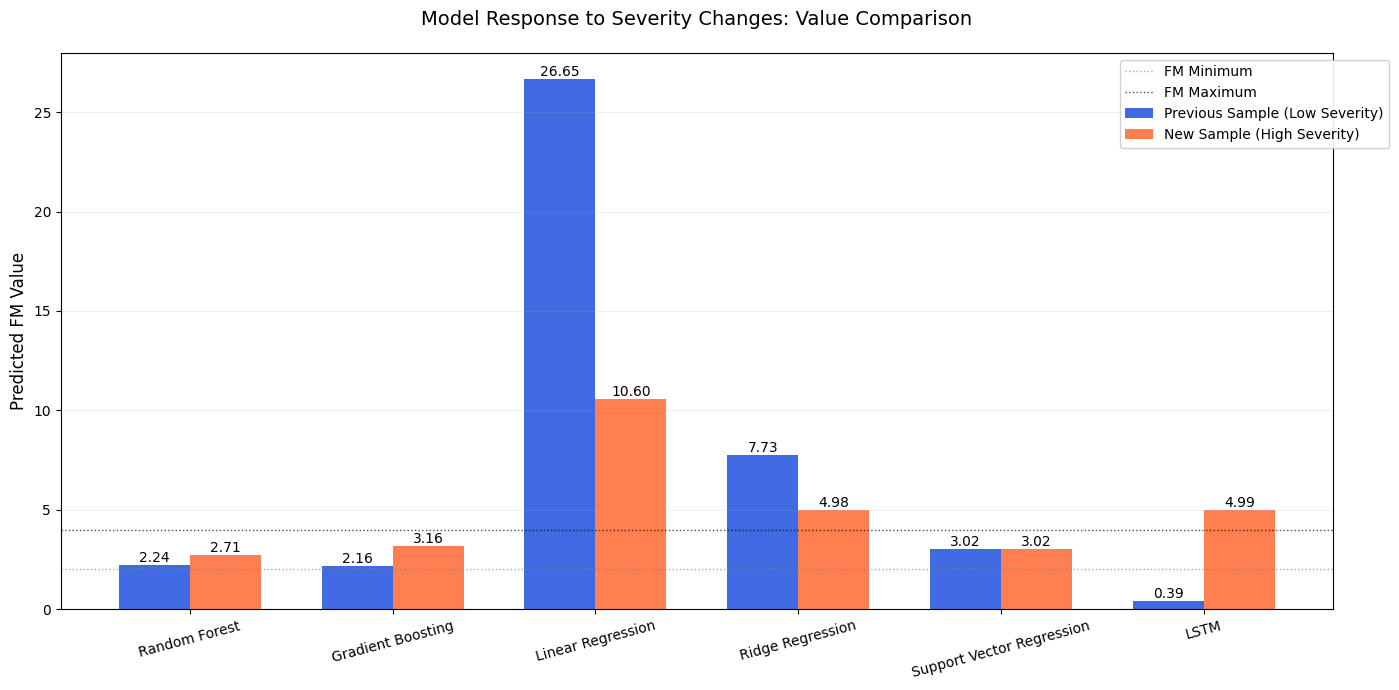

In [ ]:
# Create the comparison plot with value labels
plt.figure(figsize=(14, 7))
x = np.arange(len(new_predictions))  # Model names as x-axis
width = 0.35  # Width of the bars

# Plot bars for both samples
bars1 = plt.bar(x - width/2, predictions.values(), width,
                label='Previous Sample (Low Severity)', color='royalblue')
bars2 = plt.bar(x + width/2, new_predictions.values(), width,
                label='New Sample (High Severity)', color='coral')

# Add value labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

# Reference lines and styling
plt.axhline(y=2, color='grey', linestyle=':', linewidth=1, alpha=0.7, label='FM Minimum')
plt.axhline(y=4, color='black', linestyle=':', linewidth=1, alpha=0.7, label='FM Maximum')
plt.xticks(x, new_predictions.keys(), rotation=15)
plt.ylabel("Predicted FM Value", fontsize=12)
plt.title("Model Response to Severity Changes: Value Comparison", pad=20, fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), framealpha=0.9)

# # Add delta annotations
# for i, (prev, new) in enumerate(zip(predictions.values(), new_predictions.values())):
#     delta = new - prev
#     plt.text(x[i], max(prev, new) + 0.1,
#             f'Δ={delta:+.2f}',
#             ha='center', va='bottom', fontsize=9,
#             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))

plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


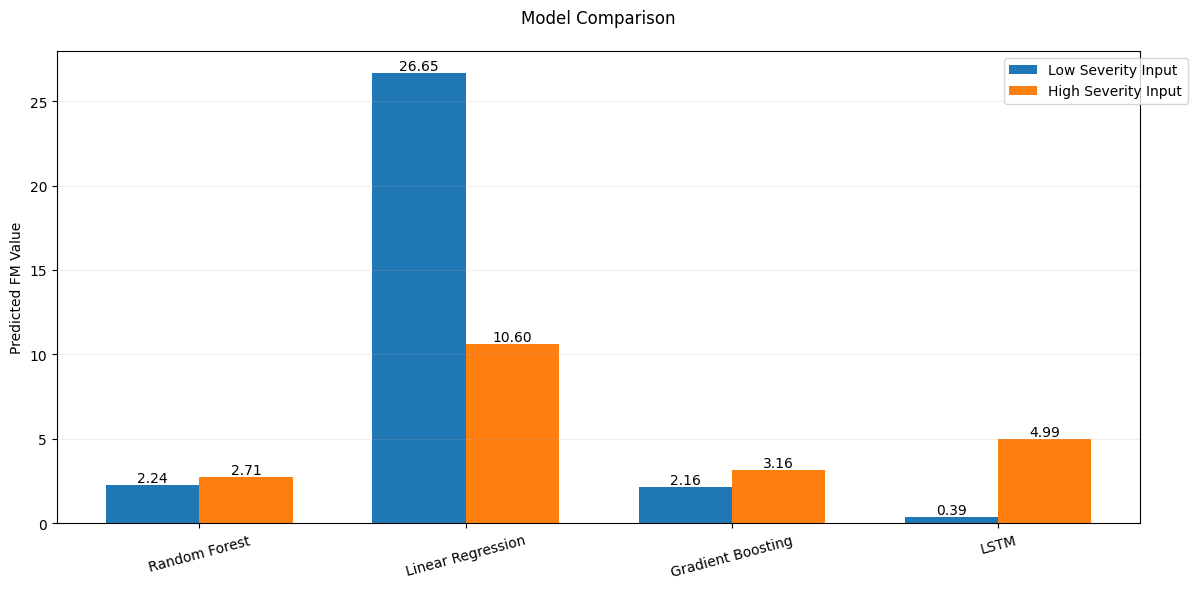

In [ ]:
# Select only the desired models
selected_models = {
    'Random Forest': models['Random Forest'],
    'Linear Regression': models['Linear Regression'],
    'Gradient Boosting': models['Gradient Boosting'],
    'LSTM': lstm_model  # Our separately trained LSTM
}

# Generate predictions for the new sample
selected_predictions = {}
for name, model in selected_models.items():
    if name == 'LSTM':
        selected_predictions[name] = model.predict(new_sample_lstm)[0][0]
    else:
        selected_predictions[name] = model.predict(new_sample_df)[0]

# Get previous predictions for these models only
previous_selected = {k: predictions[k] for k in selected_predictions.keys()}

# Create the comparison plot
plt.figure(figsize=(12, 6))
x = np.arange(len(selected_predictions))  # positions for models
width = 0.35  # bar width

# Plot bars
bars_prev = plt.bar(x - width/2, previous_selected.values(), width,
                   label='Low Severity Input', color='#1f77b4')
bars_new = plt.bar(x + width/2, selected_predictions.values(), width,
                 label='High Severity Input', color='#ff7f0e')

# Add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10)

add_labels(bars_prev)
add_labels(bars_new)

# # Add delta values
# for i, (model_name, prev_val) in enumerate(previous_selected.items()):
#     new_val = selected_predictions[model_name]
#     delta = new_val - prev_val
#     plt.text(x[i], max(prev_val, new_val) + 0.1,
#             f'Δ={delta:+.2f}',
#             ha='center', va='bottom', fontsize=9,
#             bbox=dict(facecolor='white', alpha=0.8, pad=2))

# Reference lines and styling
# plt.axhline(y=2, color='gray', linestyle=':', alpha=0.5, label='FM Min')
# plt.axhline(y=4, color='gray', linestyle=':', alpha=0.5, label='FM Max')
plt.xticks(x, selected_predictions.keys(), rotation=15)
plt.ylabel("Predicted FM Value")
plt.title("Model Comparison", pad=20)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

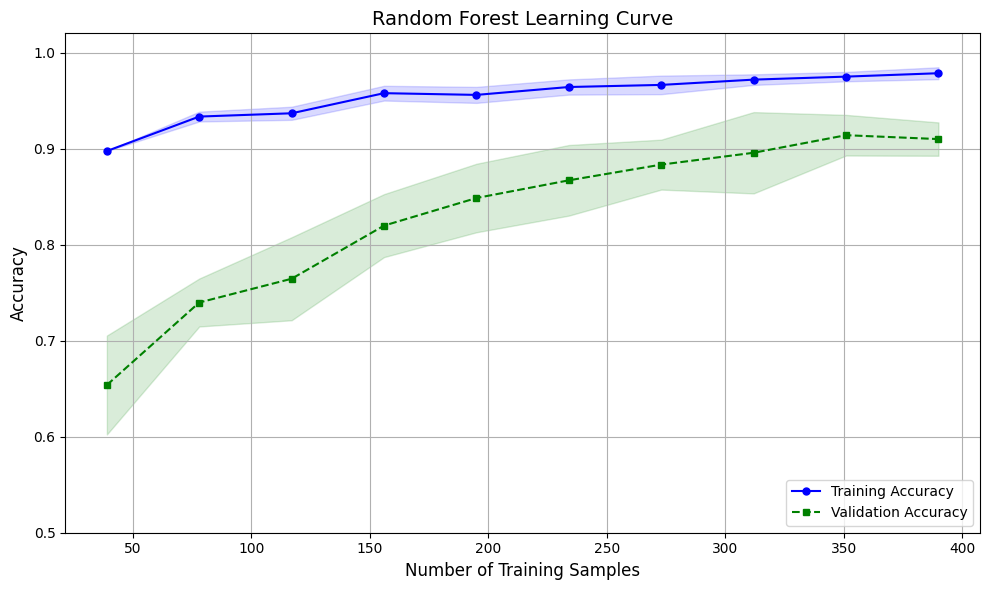

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

# Assuming you have:
# X_train, y_train for your features and target
# rf_classifier is your trained Random Forest model

# Create the learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    estimator=RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42),
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 increments from 10% to 100% of training data
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, val_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of Training Samples', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Random Forest Learning Curve', fontsize=14)
plt.legend(loc='lower right')
plt.ylim([0.5, 1.02])  # Adjust based on your accuracy range
plt.tight_layout()
plt.show()